## Statistics with Pandas

Let's find out how to massage data with pandas: We want to sum up Swiss energy production data per month, but we only have daily values.

In [52]:
import pandas as pd

energy_url = 'https://bfe-energy-dashboard-ogd.s3.amazonaws.com/ogd104_stromproduktion_swissgrid.csv'
energy_prod = pd.read_table(energy_url, sep=',')

energy_prod

,Datum,Energietraeger,Produktion_GWh
0,2014-01-01,Flusskraft,26.0
1,2014-01-01,Kernkraft,80.1
2,2014-01-01,Speicherkraft,23.1
3,2014-01-01,Thermische,10.3
4,2014-01-02,Flusskraft,26.0
...,...,...,...
19486,2023-03-13,Kernkraft,70.5
19487,2023-03-13,Photovoltaik,11.4
19488,2023-03-13,Speicherkraft,46.4
19489,2023-03-13,Thermische,10.8


### Value types and Date Formats
Hm, looks useful, let's verify what kind of data we have in the `Datum` column.

In [53]:
energy_prod.dtypes

Datum              object
Energietraeger     object
Produktion_GWh    float64
dtype: object

Aha, `Datum` is of type `object`, which can be anything - probably strings. In order to compute useful stuff, we'd prefer a datatype of `datetime64`. We can use the `to_datetime` function to convert and reassign. Since the values appear to be in the [ISO 8601](https://de.wikipedia.org/wiki/ISO_8601) format, the conversion should be smooth...

In [54]:
# Let's convert the ISO8601 values in the 'Datum' column.
energy_prod['Datum'] = pd.to_datetime(energy_prod.Datum)
energy_prod.dtypes
#energy_prod

Datum             datetime64[ns]
Energietraeger            object
Produktion_GWh           float64
dtype: object

### Extract month
We create a new column using only months.

In [55]:
energy_prod['Monat'] = energy_prod['Datum'].dt.to_period('M')
energy_prod

,Datum,Energietraeger,Produktion_GWh,Monat
0,2014-01-01,Flusskraft,26.0,2014-01
1,2014-01-01,Kernkraft,80.1,2014-01
2,2014-01-01,Speicherkraft,23.1,2014-01
3,2014-01-01,Thermische,10.3,2014-01
4,2014-01-02,Flusskraft,26.0,2014-01
...,...,...,...,...
19486,2023-03-13,Kernkraft,70.5,2023-03
19487,2023-03-13,Photovoltaik,11.4,2023-03
19488,2023-03-13,Speicherkraft,46.4,2023-03
19489,2023-03-13,Thermische,10.8,2023-03


### Group-by and Aggregation
We want to sum up the production values by month - this is where `groupby` comes in. Group-By means we group all rows that have identical values in the given columns, in our case `['Monat', 'Energietraeger']`. The final call to `sum(column)` aggregates the group's values in the given column. Yes, there are more aggregation functions such as `avg()` to summarize the data. Note that columns are dropped that are not part of the index (the group-by columns) nor of the aggregation.

In [56]:
energy_by_month = energy_prod.groupby(['Monat', 'Energietraeger']).sum('Produktion_GWh')
energy_by_month

Produktion_GWh
Monat   Energietraeger                
2014-01 Flusskraft               944.0
        Kernkraft               2472.3
        Speicherkraft           1456.6
        Thermische               319.3
2014-02 Flusskraft               818.9
...                                ...
2023-03 Kernkraft               1349.1
        Photovoltaik             178.0
        Speicherkraft           1395.4
        Thermische               205.2
        Wind                       6.5

[643 rows x 1 columns]

### Warp Table
We'd prefer a separate column for each energy type... `pivot_table` warps the values into the shape we want: `index` defines which column forms the new row index, `columns` specifies which values are turned into separate columns, and `values` tells which column is used as the values in the newly formed columns.

In [57]:
energy_table = energy_by_month.pivot_table(values='Produktion_GWh', index='Monat', columns='Energietraeger')
energy_table

Energietraeger,Flusskraft,Kernkraft,Photovoltaik,Speicherkraft,Thermische,Wind
Monat,,,,,,
2014-01,944.0,2472.3,NaN,1456.6,319.3,NaN
2014-02,818.9,2234.1,NaN,1607.6,302.4,NaN
2014-03,977.3,2466.0,NaN,1731.0,334.8,NaN
2014-04,1256.1,2255.6,NaN,1577.0,303.0,NaN
2014-05,1775.0,2450.9,NaN,1618.0,300.7,NaN
...,...,...,...,...,...,...
2022-11,935.0,2124.7,113.1,1216.7,312.0,9.8
2022-12,834.6,2202.6,78.5,1794.8,319.3,10.5
2023-01,878.5,2204.0,103.0,2588.8,319.3,12.6


### Display

Now let's plot.

Text(0, 0.5, 'GWh')

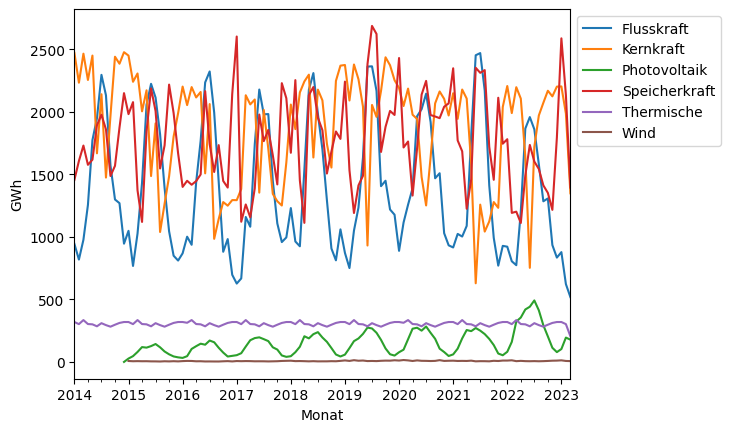

In [58]:
import matplotlib.pyplot as plt

energy_table.plot.line().legend(bbox_to_anchor=(1,1)).axes.set_ylabel("GWh")

# Also try plot.area()
